# Replicating The Results

## Preamble

In [1]:
# libraries
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

import matplotlib.pyplot as plt
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 20)

In [2]:
# load the data
DATA_PATH = "../data/class_size.dta"

def load_data(path=DATA_PATH):
    df = pd.read_stata(path).copy()
    return df

In [3]:
df = load_data()
print(df.head())

   student_id  year  twin_id  school_id  elite  gender  income  class_id  class_size  enrollments   perf
0         1.0   1.0      NaN        1.0    1.0     1.0   119.0       1.0         9.0         44.0  100.0
1         1.0   2.0      NaN        1.0    1.0     1.0   119.0       2.0        10.0         48.0  100.0
2         1.0   3.0      NaN        1.0    1.0     1.0   109.0       1.0         9.0         44.0  100.0
3         1.0   4.0      NaN        1.0    1.0     1.0   118.0       2.0         9.0         44.0  100.0
4         1.0   5.0      NaN        1.0    1.0     1.0   111.0       4.0         9.0         44.0  100.0


In [4]:
# schools 22-25 are excluded as per
df = df[~df["school_id"].isin([22, 23, 24, 25])].copy()

## Mean Performance by Class Size

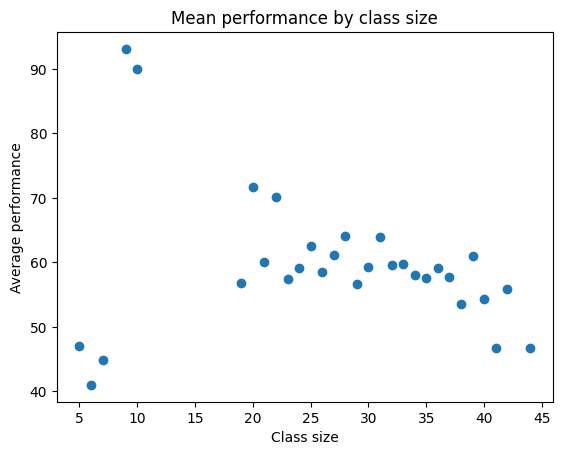

In [6]:
# report plots mean perf vs class_size
mean_by_cs = (
    df.groupby("class_size", as_index=False)["perf"]
      .mean()
      .sort_values("class_size")
)

plt.figure()
plt.scatter(mean_by_cs["class_size"], mean_by_cs["perf"])
plt.xlabel("Class size")
plt.ylabel("Average performance")
plt.title("Mean performance by class size")
plt.show()

## OLS

In [7]:
# perf on class_size
ols1 = smf.ols("perf ~ class_size", data=df).fit(cov_type="HC1")
# perf on class_size (controlled for gender, and income)
ols2 = smf.ols("perf ~ class_size + gender + income", data=df).fit(cov_type="HC1")

In [8]:
print("\n=== OLS1: perf ~ class_size===")
print(ols1.summary())


=== OLS1: perf ~ class_size===
                            OLS Regression Results                            
Dep. Variable:                   perf   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     714.4
Date:                Tue, 17 Feb 2026   Prob (F-statistic):          1.81e-154
Time:                        19:17:34   Log-Likelihood:                -80289.
No. Observations:               18585   AIC:                         1.606e+05
Df Residuals:                   18583   BIC:                         1.606e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.464

In [9]:
print("\n=== OLS2: perf ~ class_size + gender + income===")
print(ols2.summary())


=== OLS2: perf ~ class_size + gender + income===
                            OLS Regression Results                            
Dep. Variable:                   perf   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                 1.732e+04
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        19:17:34   Log-Likelihood:                -65826.
No. Observations:               18585   AIC:                         1.317e+05
Df Residuals:                   18581   BIC:                         1.317e+05
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
In

## IV - TSLS

In [10]:
# first stage (class size ~ elite)
fs = smf.ols("class_size ~ elite", data=df).fit(cov_type="HC1")
print("\n=== First stage: class_size ~ elite (robust HC1) ===")
print(fs.summary())


=== First stage: class_size ~ elite (robust HC1) ===
                            OLS Regression Results                            
Dep. Variable:             class_size   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                 1.930e+05
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        19:17:34   Log-Likelihood:                -54692.
No. Observations:               18585   AIC:                         1.094e+05
Df Residuals:                   18583   BIC:                         1.094e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [11]:
# reduced form (perf ~ elite)
rf = smf.ols("perf ~ elite", data=df).fit(cov_type="HC1")
print("\n=== Reduced form: perf ~ elite (robust HC1) ===")
print(rf.summary())


=== Reduced form: perf ~ elite (robust HC1) ===
                            OLS Regression Results                            
Dep. Variable:                   perf   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     4711.
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        19:17:34   Log-Likelihood:                -79775.
No. Observations:               18585   AIC:                         1.596e+05
Df Residuals:                   18583   BIC:                         1.596e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Int

In [12]:
# 2SLS
iv = IV2SLS.from_formula("perf ~ 1 + [class_size ~ elite]", data=df).fit(cov_type="robust")
print("\n=== 2SLS: perf ~ class_size (instrument: elite), robust ===")
print(iv.summary)


=== 2SLS: perf ~ class_size (instrument: elite), robust ===
                          IV-2SLS Estimation Summary                          
Dep. Variable:                   perf   R-squared:                     -0.0055
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0055
No. Observations:               18585   F-statistic:                    4686.9
Date:                Tue, Feb 17 2026   P-value (F-stat)                0.0000
Time:                        19:17:34   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      104.96     0.6307     166.42     0.0000      103.72    

## Findings

- The robust SE for the constant term in the OLS1 regression is reported to be $0.66$ while we obtain $0.83$
- The robust SE for the constant term in the first stage of the IV regression is reported to be $0.66$ while we obtain $0.03$

As none of the other SEs are misaligned, and their corresponding coefficients match those reported, it's reasonable to believe that our SEs are correctly computed.